In [0]:
# Import Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Transformations
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-20.0, 20.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
#Dataset and Creating Train/Test Split
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [6]:
#Dataloader Arguments & Test/Train Dataloaders

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
#Model Building 
# Build the neural network, expand on top of nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution block-1
        self.conv_blk1 = nn.Sequential(
            # input layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0,  bias=False),   
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )

        # Transition Layer for Convolution block-1
        self.conv_blk1_transition = nn.Sequential(
            nn.MaxPool2d(2, 2),                                                                     
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0,  bias=False)
         )

        # Convolution block-2
        self.conv_blk2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )

        # Output Block
        self.output_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),                                                             
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0,  bias=False),  
            # no ReLU for last covv layer
            # No Batch Normalization
        ) # output_size = 1

    def forward(self, x):

        x = self.conv_blk1(x) 
        x = self.conv_blk1_transition(x)
        x = self.conv_blk2(x) 
        x = self.output_block(x)  
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [8]:
# Model Parameters

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
#Training and Testing

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
#train_epoch_end = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss=0
    for param in model.parameters():
      zero_vector = torch.rand_like(param)*0
      reg_loss += l1_crit(param, zero_vector)
    factor = 0.0005
    loss += factor*reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.4828507900238037 Batch_id=468 Accuracy=93.00: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Accuracy: 9687/10000 (96.87%)

EPOCH: 1


Loss=0.38070836663246155 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Accuracy: 9671/10000 (96.71%)

EPOCH: 2


Loss=0.32955700159072876 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1254, Accuracy: 9600/10000 (96.00%)

EPOCH: 3


Loss=0.34118014574050903 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0933, Accuracy: 9720/10000 (97.20%)

EPOCH: 4


Loss=0.30754971504211426 Batch_id=468 Accuracy=96.46: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Accuracy: 9687/10000 (96.87%)

EPOCH: 5


Loss=0.2675856351852417 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0876, Accuracy: 9741/10000 (97.41%)

EPOCH: 6


Loss=0.33936530351638794 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:13<00:00, 39.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9803/10000 (98.03%)

EPOCH: 7


Loss=0.3754296600818634 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0882, Accuracy: 9727/10000 (97.27%)

EPOCH: 8


Loss=0.4330154061317444 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 9820/10000 (98.20%)

EPOCH: 9


Loss=0.3493582606315613 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:14<00:00, 40.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9783/10000 (97.83%)

EPOCH: 10


Loss=0.248004749417305 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9808/10000 (98.08%)

EPOCH: 11


Loss=0.35745665431022644 Batch_id=468 Accuracy=96.52: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9675/10000 (96.75%)

EPOCH: 12


Loss=0.310968279838562 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:13<00:00, 40.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9774/10000 (97.74%)

EPOCH: 13


Loss=0.2908942997455597 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0888, Accuracy: 9696/10000 (96.96%)

EPOCH: 14


Loss=0.2605111002922058 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0619, Accuracy: 9809/10000 (98.09%)

EPOCH: 15


Loss=0.2981660068035126 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0805, Accuracy: 9725/10000 (97.25%)

EPOCH: 16


Loss=0.2454981654882431 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0799, Accuracy: 9751/10000 (97.51%)

EPOCH: 17


Loss=0.2843833267688751 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:13<00:00, 40.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9768/10000 (97.68%)

EPOCH: 18


Loss=0.3006686866283417 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9768/10000 (97.68%)

EPOCH: 19


Loss=0.3454708755016327 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9817/10000 (98.17%)

EPOCH: 20


Loss=0.3387262523174286 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9789/10000 (97.89%)

EPOCH: 21


Loss=0.2856639623641968 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9777/10000 (97.77%)

EPOCH: 22


Loss=0.2703557014465332 Batch_id=468 Accuracy=96.57: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9804/10000 (98.04%)

EPOCH: 23


Loss=0.3294121026992798 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1083, Accuracy: 9672/10000 (96.72%)

EPOCH: 24


Loss=0.34763002395629883 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9826/10000 (98.26%)

EPOCH: 25


Loss=0.3842899203300476 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1091, Accuracy: 9652/10000 (96.52%)

EPOCH: 26


Loss=0.28037384152412415 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:14<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1383, Accuracy: 9577/10000 (95.77%)

EPOCH: 27


Loss=0.2170616090297699 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Accuracy: 9792/10000 (97.92%)

EPOCH: 28


Loss=0.2781938910484314 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9847/10000 (98.47%)

EPOCH: 29


Loss=0.2867635488510132 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1060, Accuracy: 9658/10000 (96.58%)

EPOCH: 30


Loss=0.3309427797794342 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9794/10000 (97.94%)

EPOCH: 31


Loss=0.3610585927963257 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0824, Accuracy: 9740/10000 (97.40%)

EPOCH: 32


Loss=0.2686001658439636 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9817/10000 (98.17%)

EPOCH: 33


Loss=0.3377127945423126 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9837/10000 (98.37%)

EPOCH: 34


Loss=0.24071770906448364 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9805/10000 (98.05%)

EPOCH: 35


Loss=0.24352461099624634 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9834/10000 (98.34%)

EPOCH: 36


Loss=0.29809850454330444 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 9707/10000 (97.07%)

EPOCH: 37


Loss=0.2818664610385895 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1096, Accuracy: 9682/10000 (96.82%)

EPOCH: 38


Loss=0.291326105594635 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0846, Accuracy: 9725/10000 (97.25%)

EPOCH: 39


Loss=0.2893267869949341 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]



Test set: Average loss: 0.0629, Accuracy: 9797/10000 (97.97%)



Text(0, 0.5, 'Accuracy')

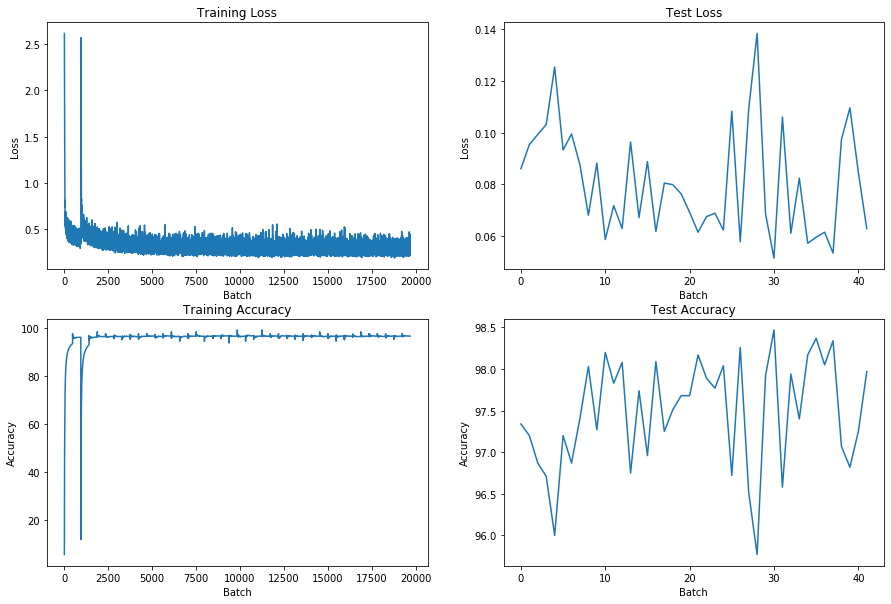

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_xlabel("Batch")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel("Batch")
axs[1, 0].set_ylabel("Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[0, 1].set_xlabel("Batch")
axs[0, 1].set_ylabel("Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].set_xlabel("Batch")
axs[1, 1].set_ylabel("Accuracy")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


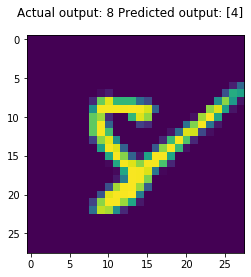

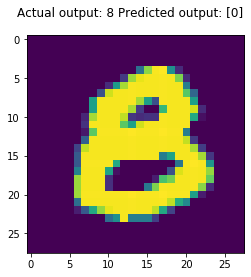

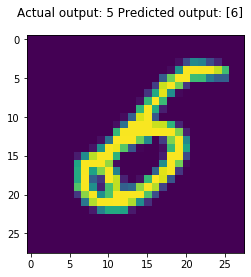

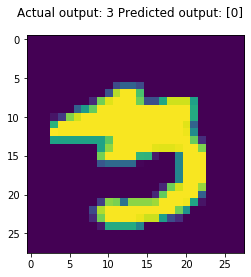

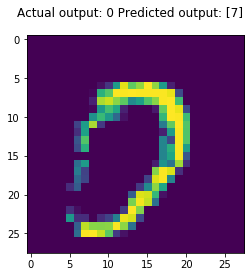

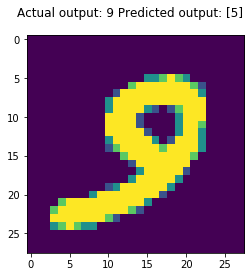

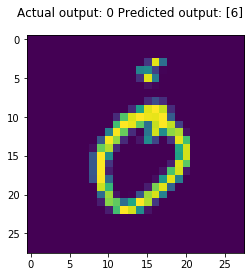

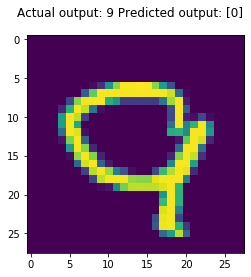

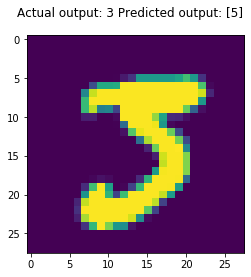

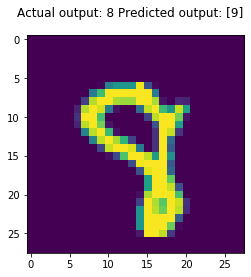

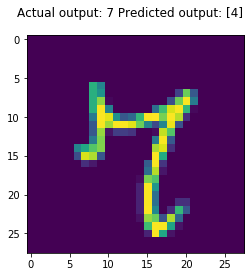

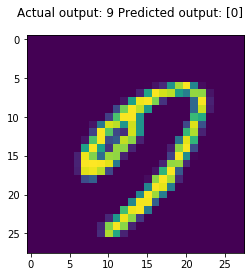

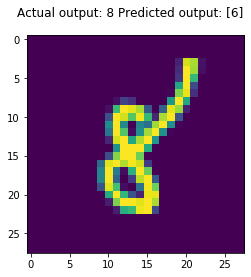

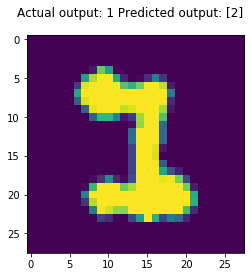

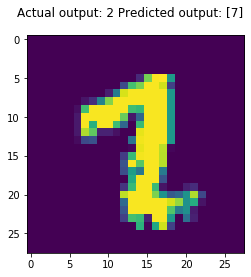

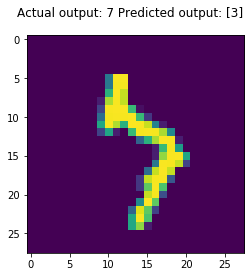

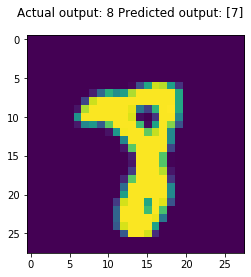

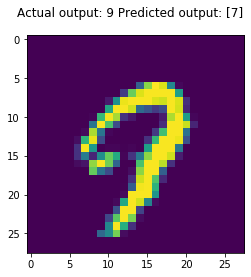

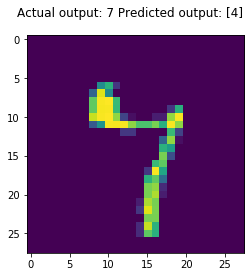

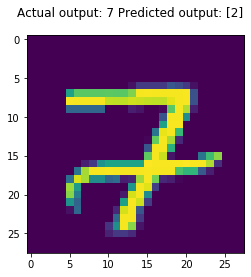

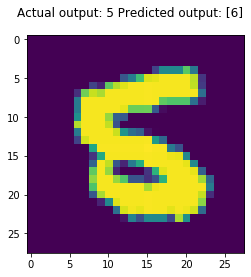

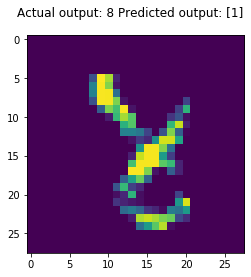

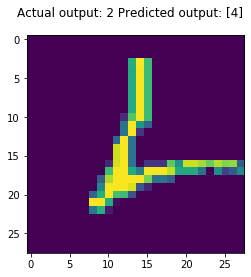

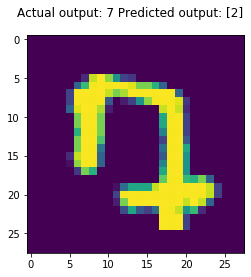

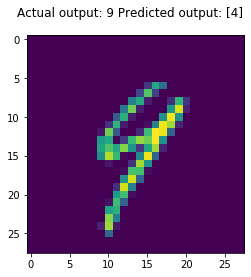

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig(str(count)+".jpg")
                files.download(str(count)+".jpg")
                count = count+1